In [1]:
import numpy as np
import pandas as pd 
import re
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
# import nltk
# import spacy                                       ## pip install -U spacy
# from nltk.tokenize.toktok import ToktokTokenizer
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [2]:
from nltk.cluster import KMeansClusterer
import nltk
from sklearn.manifold import TSNE

In [3]:
from sklearn.cluster import KMeans

In [4]:
data = pd.read_csv('fbportal_new.csv')
data.head()

,Test Case Description,Label
0,What's the weather like in Chicago?,Weather
1,What is the forecast in Tampa for tomorrow?,Weather
2,What is the weather in Oregon today?,Weather
3,Is it raining in France right now?,Weather
4,Show me the weather in Mexico for next week.,Weather


In [5]:
data.shape

(827, 2)

In [6]:
len(data['Label'].value_counts())

17

### Merging of all the Labels

Music/Music_QA/Birthday :: Person entity :: whose birthday :: Music

Calling/WhatsApp_calling : Calling : What entity we should get? Person

Photo/Device :: Device 

Help_touchScreen/Help :: Help

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827 entries, 0 to 826
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Test Case Description  827 non-null    object
 1   Label                  827 non-null    object
dtypes: object(2)
memory usage: 13.0+ KB


In [8]:
(~data.duplicated()).sum()

740

In [9]:
def text_cleaner(text):
   
    newString = text.lower()
    newString = re.sub(r"pre-conditions:","",newString)
    newString = re.sub(r"precondition:","",newString)
    newString = re.sub(r"hey","",newString)
    newString = re.sub(r"portal","",newString)
    newString = re.sub(r"hp","",newString)
    newString = re.sub(r"[^a-zA-Z]+", ' ', newString)
    #newString = remove_stopwords(newString)
    return newString

In [10]:
#call the function
cleaned_text = []
data['Test Case Description']=data['Test Case Description'].astype(str)
for t in data['Test Case Description']:
    cleaned_text.append(text_cleaner(t))
data['cleaned_text']=cleaned_text

In [11]:
print('The number of duplicate records are: ',data.duplicated().sum())
# Extract duplicate rows
data.loc[data.duplicated(), :]

The number of duplicate records are:  87


,Test Case Description,Label,cleaned_text
361,"\n ""Play the podcast This Past Weekend",Music,play the podcast this past weekend
365,"\n ""Play the podcast Myths & Legends",Music,play the podcast myths legends
373,"\n ""Play the podcast Literally! with Rob Lowe",Music,play the podcast literally with rob lowe
374,"\n ""Play the podcast The Weeds",Music,play the podcast the weeds
381,"\n ""Play the podcast The Rubin Report",Music,play the podcast the rubin report
...,...,...,...
591,Turn repeat off,Music,turn repeat off
724,HP Install WhatsApp,Calling,install whatsapp
730,HP Call Kim on WhatsApp (contact in your WhatsApp contact list),Calling,call kim on whatsapp contact in your whatsapp contact list
757,HP Call John on WhatsApp\n,Calling,call john on whatsapp


In [12]:
### Dropping duplicates
data.drop_duplicates(keep='first', inplace=True)

In [13]:
data.shape

(740, 3)

In [14]:
len(data['Label'].value_counts())

17

In [15]:
data.tail()

,Test Case Description,Label,cleaned_text
821,"\n From Ambient, IE not logged in: ""Hey Portal, join [room name]""\n",Assistant_messenger,from ambient ie not logged in join room name
822,"\n ""Hey Portal, leave [room name for a room that doesn't exist] room""",Assistant_messenger,leave room name for a room that doesn t exist room
823,"\n ""Hey Portal, leave room""",Assistant_messenger,leave room
824,"\n ""Hey Portal, leave room.""",Assistant_messenger,leave room
825,"\n ""Hey Portal, end room.""",Assistant_messenger,end room


## Sentence Embedding and applying clustering on it by using sentence_transformers

#### Trying with all-distilroberta-v1 pre-trained model



In [16]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-distilroberta-v1')

In [17]:
def embeddings(data):
    sentence_embeddings = model.encode(list(data['cleaned_text']))
    return sentence_embeddings
embeddings_trs=embeddings(data)
data['embediing_trf_roberta']=list(embeddings_trs)

### Clustering by KMeansClusterer

In [18]:
def clustering_data_trf(data,NUM_CLUSTERS = 17):

    sentences = data['cleaned_text']

    X = np.array(data['embediing_trf_roberta'].tolist())

    kclusterer = KMeansClusterer(
        NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance,
        repeats=25,avoid_empty_clusters=True)

    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

    data['cluster_trf_roberta'] = pd.Series(assigned_clusters, index=data.index)
    data['centroid_trf_roberta'] = data['cluster_trf_roberta'].apply(lambda x: kclusterer.means()[x])
    return data, assigned_clusters

In [19]:
data, cluster_trf=clustering_data_trf(data)

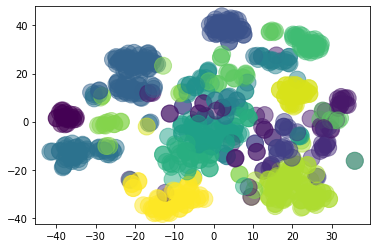

In [20]:
X = np.array(data['embediing_trf_roberta'].tolist())

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

Y=model.fit_transform(X)

plt.scatter(Y[:, 0], Y[:, 1], c=cluster_trf, s=290,alpha=.5)
plt.show()

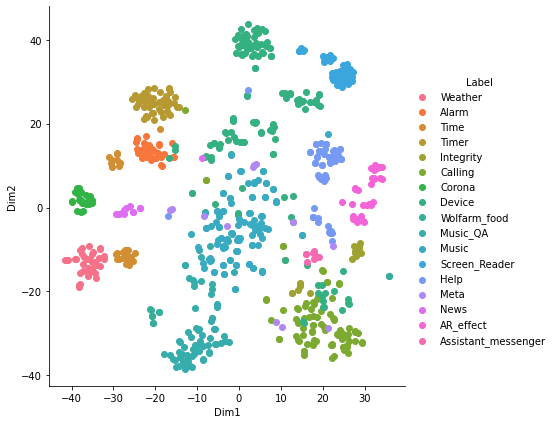

In [22]:
tnse_data=np.vstack((Y.T, data['Label'])).T
#tnse_data=np.vstack((Y.T, cluster_trf)).T
tsne_df=pd.DataFrame(data=tnse_data, columns=('Dim1','Dim2','Label'))

sns.FacetGrid(tsne_df, hue="Label", size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

In [66]:
data.tail()

,Test Case Description,Label,cleaned_text,embediing_trf_roberta,cluster_trf_roberta,centroid_trf_roberta
821,"\n From Ambient, IE not logged in: ""Hey Portal, join [room name]""\n",Assistant_messenger,from ambient ie not logged in join room name,"[0.014328602, -0.044547908, -0.0027392164, -0.017430108, -0.05330457, -0.014606708, -0.014662344, -0.031228267, -0.030140312, -0.048513398, -0.0022124653, -0.05474573, -0.04499313, -0.07480648, -0...",12,"[0.015779203, 0.018161843, -0.011395321, -0.008218243, -0.041130167, -0.062703855, -0.017370054, -0.01749752, 0.029519567, 0.0061123976, -0.0002038584, -0.05356958, -0.033857953, -0.02314356, -0.0..."
822,"\n ""Hey Portal, leave [room name for a room that doesn't exist] room""",Assistant_messenger,leave room name for a room that doesn t exist room,"[0.0013551848, -0.034606256, 0.020703442, -0.009431288, -0.020030769, -0.010434812, 0.021187013, 0.034395453, 0.0050038747, -0.021688335, 0.044945795, -0.0656787, -0.020550536, -0.13303293, 0.0129...",0,"[0.00956512, -0.012171338, -0.010282495, 0.00464952, 0.0005709904, -0.054812316, 0.00682091, 0.014205539, 0.0236003, -0.031953726, 0.0007496282, -0.03509832, -0.007819219, -0.02689806, -0.01927935..."
823,"\n ""Hey Portal, leave room""",Assistant_messenger,leave room,"[-0.005868537, -0.08784454, -0.006600823, -0.018835427, 0.029957088, -0.03967343, -0.023587223, 0.03608167, 0.01724136, -0.08257513, 0.05590372, -0.06915631, 0.00853614, -0.122166194, 0.0062098084...",0,"[0.00956512, -0.012171338, -0.010282495, 0.00464952, 0.0005709904, -0.054812316, 0.00682091, 0.014205539, 0.0236003, -0.031953726, 0.0007496282, -0.03509832, -0.007819219, -0.02689806, -0.01927935..."
824,"\n ""Hey Portal, leave room.""",Assistant_messenger,leave room,"[-0.005868537, -0.08784454, -0.006600823, -0.018835427, 0.029957088, -0.03967343, -0.023587223, 0.03608167, 0.01724136, -0.08257513, 0.05590372, -0.06915631, 0.00853614, -0.122166194, 0.0062098084...",0,"[0.00956512, -0.012171338, -0.010282495, 0.00464952, 0.0005709904, -0.054812316, 0.00682091, 0.014205539, 0.0236003, -0.031953726, 0.0007496282, -0.03509832, -0.007819219, -0.02689806, -0.01927935..."
825,"\n ""Hey Portal, end room.""",Assistant_messenger,end room,"[-0.00036559885, -0.07358209, 0.007445581, 0.06040384, -0.018131457, -0.013287523, -0.005839103, 0.04040454, 0.021870019, -0.04618962, 0.0049777487, -0.056641094, -0.016894706, -0.11162299, -0.041...",0,"[0.00956512, -0.012171338, -0.010282495, 0.00464952, 0.0005709904, -0.054812316, 0.00682091, 0.014205539, 0.0236003, -0.031953726, 0.0007496282, -0.03509832, -0.007819219, -0.02689806, -0.01927935..."


In [67]:
pd.set_option('display.max_rows', 500)
df1=pd.DataFrame(data.groupby(['Label','cluster_trf_roberta'])['cluster_trf_roberta'].count())
df1.rename(columns = {'cluster_trf_roberta':'Count'}, inplace = True)
df1

Count
Label               cluster_trf_roberta       
AR_effect           0                       12
                    3                       17
Alarm               1                        2
                    6                       28
Assistant_messenger 0                        7
                    12                       1
Calling             0                        5
                    3                        2
                    7                       25
                    9                        2
                    12                      26
                    13                      29
Corona              5                       21
Device              0                       14
                    2                       54
                    4                        1
                    6                        3
                    7                       11
                    8                        8
                    9                       37
                    10                       2
                    13                       3
Help                0                       11
                    9                        2
                    14                      38
Integrity           0                       12
                    7                        1
                    13                       3
Meta                4                        1
                    7                        2
                    10                       6
                    13                       3
Music               0                        1
                    3                        2
                    9                        1
                    10                      67
                    11                      40
Music_QA            0                        1
                    10                      15
                    11                       1
                    15                      54
News                5                        9
                    9                        3
Screen_Reader       8                       34
                    9                        5
Time                1                        1
                    5                       15
                    6                       10
Timer               1                       47
Weather             4                       35
Wolfarm_food        8                        3
                    15                       7

### Clustering by using KMean
#### Validating with silhouette analysis

For n_clusters=8, the silhouette score is 0.10930915921926498
For n_clusters=9, the silhouette score is 0.11881691217422485
For n_clusters=10, the silhouette score is 0.12200243026018143
For n_clusters=11, the silhouette score is 0.12828253209590912
For n_clusters=12, the silhouette score is 0.12565630674362183
For n_clusters=13, the silhouette score is 0.12827908992767334
For n_clusters=14, the silhouette score is 0.1269432008266449
For n_clusters=15, the silhouette score is 0.13505250215530396
For n_clusters=16, the silhouette score is 0.1347326785326004
For n_clusters=17, the silhouette score is 0.1339777410030365
For n_clusters=18, the silhouette score is 0.13670501112937927
For n_clusters=19, the silhouette score is 0.13463439047336578
For n_clusters=20, the silhouette score is 0.14361098408699036
For n_clusters=21, the silhouette score is 0.14473871886730194
For n_clusters=22, the silhouette score is 0.1400269865989685
For n_clusters=23, the silhouette score is 0.1432440727949142

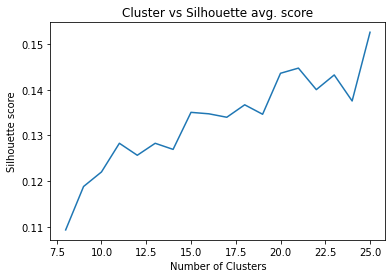

In [68]:
# silhouette analysis
import seaborn as sna
from sklearn.metrics import silhouette_score
range_n_clusters = [8,9,10, 11, 12,13,14,15,16,17,18,19,20,21,22,23,24,25]
score =[]
for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters,max_iter=50, algorithm='auto', init='k-means++',n_init=10)
    kmeans.fit(list(data['embediing_trf_roberta']))
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(list(data['embediing_trf_roberta']), cluster_labels)
    score.append(silhouette_avg)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
sns.lineplot(range_n_clusters,score)
plt.title('Cluster vs Silhouette avg. score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette score')
plt.show()

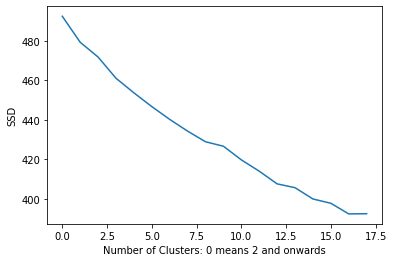

In [69]:
# elbow-curve/SSD
ssd=[]
range_n_clusters = [8,9,10, 11, 12,13,14,15,16,17,18,19,20,21,22,23,24,25]
for num_clusters in range_n_clusters:
    kmeans=KMeans(n_clusters=num_clusters,max_iter=50)
    kmeans.fit(list(data['embediing_trf_roberta']))
    ssd.append(kmeans.inertia_)
plt.plot(ssd)
plt.xlabel('Number of Clusters: 0 means 2 and onwards')
plt.ylabel('SSD')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters={
            'init' : ['k-means++', 'random'],
            'algorithm' : ["auto", "full", "elkan"],
            'max_iter' : [50,100,200,300],
            'n_init' : [10,20,30,40]
    
            }
clustering_model = KMeans(n_clusters=num_clusters,n_jobs=-1)
grid = GridSearchCV(clustering_model, cv=5, param_grid = parameters, scoring = 
    silhouette_score)

grid.fit(list(data['embediing_trf_roberta']))
print(grid.best_params_)

In [75]:
# Perform kmean clustering
num_clusters = 17
clustering_model = KMeans(n_clusters=num_clusters,max_iter=100, algorithm='auto', init='k-means++',n_init=50 )
clustering_model.fit(list(data['embediing_trf_roberta']))
cluster_assignment = clustering_model.labels_
data['Cluster_name']=cluster_assignment

In [76]:
data.tail()

,Test Case Description,Label,cleaned_text,embediing_trf_roberta,cluster_trf_roberta,centroid_trf_roberta,Cluster_name
821,"\n From Ambient, IE not logged in: ""Hey Portal, join [room name]""\n",Assistant_messenger,from ambient ie not logged in join room name,"[0.014328602, -0.044547908, -0.0027392164, -0.017430108, -0.05330457, -0.014606708, -0.014662344, -0.031228267, -0.030140312, -0.048513398, -0.0022124653, -0.05474573, -0.04499313, -0.07480648, -0...",12,"[0.015779203, 0.018161843, -0.011395321, -0.008218243, -0.041130167, -0.062703855, -0.017370054, -0.01749752, 0.029519567, 0.0061123976, -0.0002038584, -0.05356958, -0.033857953, -0.02314356, -0.0...",0
822,"\n ""Hey Portal, leave [room name for a room that doesn't exist] room""",Assistant_messenger,leave room name for a room that doesn t exist room,"[0.0013551848, -0.034606256, 0.020703442, -0.009431288, -0.020030769, -0.010434812, 0.021187013, 0.034395453, 0.0050038747, -0.021688335, 0.044945795, -0.0656787, -0.020550536, -0.13303293, 0.0129...",0,"[0.00956512, -0.012171338, -0.010282495, 0.00464952, 0.0005709904, -0.054812316, 0.00682091, 0.014205539, 0.0236003, -0.031953726, 0.0007496282, -0.03509832, -0.007819219, -0.02689806, -0.01927935...",1
823,"\n ""Hey Portal, leave room""",Assistant_messenger,leave room,"[-0.005868537, -0.08784454, -0.006600823, -0.018835427, 0.029957088, -0.03967343, -0.023587223, 0.03608167, 0.01724136, -0.08257513, 0.05590372, -0.06915631, 0.00853614, -0.122166194, 0.0062098084...",0,"[0.00956512, -0.012171338, -0.010282495, 0.00464952, 0.0005709904, -0.054812316, 0.00682091, 0.014205539, 0.0236003, -0.031953726, 0.0007496282, -0.03509832, -0.007819219, -0.02689806, -0.01927935...",1
824,"\n ""Hey Portal, leave room.""",Assistant_messenger,leave room,"[-0.005868537, -0.08784454, -0.006600823, -0.018835427, 0.029957088, -0.03967343, -0.023587223, 0.03608167, 0.01724136, -0.08257513, 0.05590372, -0.06915631, 0.00853614, -0.122166194, 0.0062098084...",0,"[0.00956512, -0.012171338, -0.010282495, 0.00464952, 0.0005709904, -0.054812316, 0.00682091, 0.014205539, 0.0236003, -0.031953726, 0.0007496282, -0.03509832, -0.007819219, -0.02689806, -0.01927935...",1
825,"\n ""Hey Portal, end room.""",Assistant_messenger,end room,"[-0.00036559885, -0.07358209, 0.007445581, 0.06040384, -0.018131457, -0.013287523, -0.005839103, 0.04040454, 0.021870019, -0.04618962, 0.0049777487, -0.056641094, -0.016894706, -0.11162299, -0.041...",0,"[0.00956512, -0.012171338, -0.010282495, 0.00464952, 0.0005709904, -0.054812316, 0.00682091, 0.014205539, 0.0236003, -0.031953726, 0.0007496282, -0.03509832, -0.007819219, -0.02689806, -0.01927935...",1


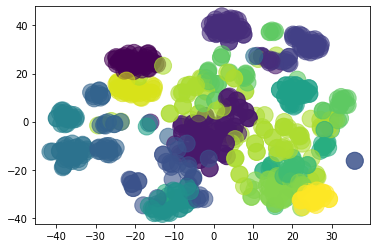

In [72]:
X = np.array(data['embediing_trf_roberta'].tolist())

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

Y=model.fit_transform(X)

plt.scatter(Y[:, 0], Y[:, 1], c=cluster_assignment, s=290,alpha=.6)
plt.show()

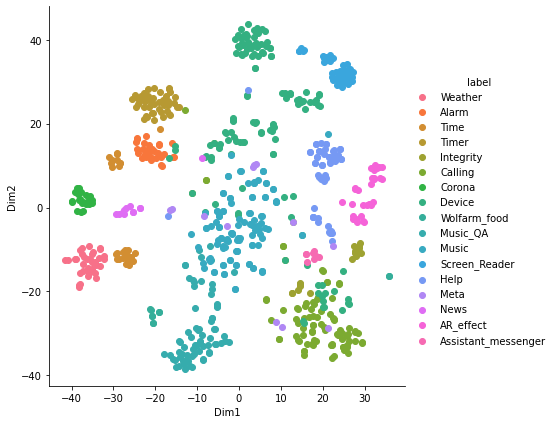

In [77]:
tnse_data=np.vstack((Y.T, data['Label'])).T
tsne_df=pd.DataFrame(data=tnse_data, columns=('Dim1','Dim2','label'))

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

In [78]:
l2c = dict(zip(list(data.Label),data.Cluster_name))
sorted(l2c.items())
clusters= [y for x,y in sorted(l2c.items()) ]
sorted(l2c.items())

[('AR_effect', 1),
 ('Alarm', 7),
 ('Assistant_messenger', 1),
 ('Calling', 3),
 ('Corona', 8),
 ('Device', 0),
 ('Help', 10),
 ('Integrity', 1),
 ('Meta', 12),
 ('Music', 6),
 ('Music_QA', 11),
 ('News', 0),
 ('Screen_Reader', 5),
 ('Time', 16),
 ('Timer', 9),
 ('Weather', 15),
 ('Wolfarm_food', 4)]

In [79]:
pd.set_option('display.max_rows', 500)
df=pd.DataFrame(data.groupby(['Label','Cluster_name'])['Cluster_name'].count())
df.rename(columns = {'Cluster_name':'Count'}, inplace = True)
df


Count
Label               Cluster_name       
AR_effect           0                 1
                    1                28
Alarm               1                 3
                    7                26
                    9                 1
Assistant_messenger 0                 1
                    1                 7
Calling             0                 2
                    1                10
                    3                26
                    4                 1
                    12               50
Corona              8                21
Device              0                41
                    1                14
                    2                45
                    5                 6
                    6                 1
                    7                 1
                    12               13
                    14               12
Help                0                 2
                    1                11
                    10               37
                    15                1
Integrity           1                11
                    12                5
Meta                0                 4
                    1                 1
                    4                 2
                    6                 1
                    12                2
                    13                1
                    15                1
Music               0                 1
                    1                 9
                    6                52
                    12                3
                    13               45
                    16                1
Music_QA            4                42
                    6                 1
                    11               24
                    13                4
News                0                 3
                    16                9
Screen_Reader       0                 5
                    5                34
Time                1                 1
                    16               25
Timer               9                47
Weather             1                 1
                    15               34
Wolfarm_food        4                10

In [80]:
df3=pd.DataFrame(data['Label'].value_counts()).sort_index()

df3.rename(columns = {'Label':'Actual_Count'}, inplace = True)
df3

,Actual_Count
AR_effect,29
Alarm,30
Assistant_messenger,8
Calling,89
Corona,21
Device,133
Help,51
Integrity,16
Meta,12
Music,111


In [81]:
#df4=data[data['Cluster_name'].isin(clusters)].sort_values('Label')
df4=data.sort_values('Label')
df5= pd.DataFrame(df4['Cluster_name'].value_counts(sort=False))
df5.rename(columns = {'Cluster_name':'Cluster_Count'}, inplace = True)
df5

,Cluster_Count
1,96
0,60
7,27
9,48
12,73
4,55
3,26
8,21
2,45
5,40


In [94]:
df3['Cluster_count']=[96,27,96,26,21, 60,37,96,73,55,24,60,40,35,48,36,4]
df3['Misclassified'] = abs(df3['Actual_Count']-df3['Cluster_count'])
df3

,Actual_Count,Cluster_count,Misclassified
AR_effect,29,96,67
Alarm,30,27,3
Assistant_messenger,8,96,88
Calling,89,26,63
Corona,21,21,0
Device,133,60,73
Help,51,37,14
Integrity,16,96,80
Meta,12,73,61
Music,111,55,56


In [87]:
print(sorted(l2c.items()))

[('AR_effect', 1), ('Alarm', 7), ('Assistant_messenger', 1), ('Calling', 3), ('Corona', 8), ('Device', 0), ('Help', 10), ('Integrity', 1), ('Meta', 12), ('Music', 6), ('Music_QA', 11), ('News', 0), ('Screen_Reader', 5), ('Time', 16), ('Timer', 9), ('Weather', 15), ('Wolfarm_food', 4)]


In [90]:
l2c = dict(zip(list(data.Label),data.Cluster_name))
print(sorted(l2c.items()))
#clusters= [y for x,y in sorted(l2c.items()) ]
df4=data.sort_values('Label')
df5= pd.DataFrame(df4['Cluster_name'].value_counts(sort=False))
df5.rename(columns = {'Cluster_name':'Cluster_Count'}, inplace = True)
df3=pd.DataFrame(data['Label'].value_counts()).sort_index()
df3.rename(columns = {'Label':'Actual_Count'}, inplace = True)
df3['Cluster_count']=list(df5['Cluster_Count'])
df3['Misclassified'] = abs(df3['Actual_Count']-df3['Cluster_count'])
df3

[('AR_effect', 1), ('Alarm', 7), ('Assistant_messenger', 1), ('Calling', 3), ('Corona', 8), ('Device', 0), ('Help', 10), ('Integrity', 1), ('Meta', 12), ('Music', 6), ('Music_QA', 11), ('News', 0), ('Screen_Reader', 5), ('Time', 16), ('Timer', 9), ('Weather', 15), ('Wolfarm_food', 4)]


,Actual_Count,Cluster_count,Misclassified
AR_effect,29,96,67
Alarm,30,60,30
Assistant_messenger,8,27,19
Calling,89,48,41
Corona,21,73,52
Device,133,55,78
Help,51,26,25
Integrity,16,21,5
Meta,12,45,33
Music,111,40,71


In [ ]:
pd.set_option('display.max_rows', 500)
x=data[data['Cluster_name']==7][['cleaned_text','Label','Cluster_name']]
print(len(x))
x


In [85]:
data.head()

,Test Case Description,Label,cleaned_text,embediing_trf_roberta,cluster_trf_roberta,centroid_trf_roberta,Cluster_name
0,What's the weather like in Chicago?,Weather,what s the weather like in chicago,"[0.0049971137, -0.004829919, -0.002093518, -0.011192511, 0.053080123, 0.07482335, 0.08083462, -0.076208994, 0.016714271, -0.0100598065, 0.026147652, 0.044739198, -0.0118344985, 0.005798026, -0.044...",4,"[0.032598164, -0.003445565, 0.0013620793, -0.021751875, 0.022197798, -0.008516662, 0.023846265, -0.035094287, 0.026739042, -0.004239254, 0.0019052415, -0.0052194195, 0.009214231, -0.033988256, -0....",15
1,What is the forecast in Tampa for tomorrow?,Weather,what is the forecast in tampa for tomorrow,"[0.07198089, -0.026893105, -0.015543571, -0.027366558, -0.015352038, 0.040792372, -0.027097687, -0.028178621, 0.04818771, -0.013843507, 0.010946429, 0.049144637, -0.009263375, -0.0071644057, -0.05...",4,"[0.032598164, -0.003445565, 0.0013620793, -0.021751875, 0.022197798, -0.008516662, 0.023846265, -0.035094287, 0.026739042, -0.004239254, 0.0019052415, -0.0052194195, 0.009214231, -0.033988256, -0....",15
2,What is the weather in Oregon today?,Weather,what is the weather in oregon today,"[0.06705808, 0.020417571, -0.0066271345, -0.05422055, 0.048431773, 0.016688075, 0.053447366, -0.04941282, 0.028920578, 0.02497368, 0.06586714, -0.057381224, -0.013937637, -0.0096998215, -0.0137277...",4,"[0.032598164, -0.003445565, 0.0013620793, -0.021751875, 0.022197798, -0.008516662, 0.023846265, -0.035094287, 0.026739042, -0.004239254, 0.0019052415, -0.0052194195, 0.009214231, -0.033988256, -0....",15
3,Is it raining in France right now?,Weather,is it raining in france right now,"[0.011582066, 0.0017562727, 0.013468675, 0.005489919, 0.057621952, 0.0063134413, 0.0039612614, -0.008079021, -0.0015483785, -0.013398306, 0.009841888, -0.023948066, 0.016747193, -0.013352445, -0.0...",4,"[0.032598164, -0.003445565, 0.0013620793, -0.021751875, 0.022197798, -0.008516662, 0.023846265, -0.035094287, 0.026739042, -0.004239254, 0.0019052415, -0.0052194195, 0.009214231, -0.033988256, -0....",15
4,Show me the weather in Mexico for next week.,Weather,show me the weather in mexico for next week,"[0.010196658, -0.008585214, 0.024786202, -0.048040077, -0.0021617538, -0.0022086082, -0.012888203, -0.035521228, 0.059188295, -0.05635977, -0.06711338, -0.040936757, 0.023869397, -0.061716944, -0....",4,"[0.032598164, -0.003445565, 0.0013620793, -0.021751875, 0.022197798, -0.008516662, 0.023846265, -0.035094287, 0.026739042, -0.004239254, 0.0019052415, -0.0052194195, 0.009214231, -0.033988256, -0....",15


In [ ]:
data[data['Test Case Description']=='what instruments lady gaga plays'][['cleaned_text','Label','Cluster_name']]

In [ ]:
import spacy
from spacy import displacy

NER = spacy.load("en_core_web_sm")

In [ ]:
text3= NER("could you turn this down a little bit")

In [ ]:
displacy.render(text3,style="ent",jupyter=True)

In [ ]:
text3= NER("show me the weather in mexico for next week")
displacy.render(text3,style="ent",jupyter=True)